# Lane Detection

In [1]:
!which python

'which' is not recognized as an internal or external command,
operable program or batch file.


## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
from itertools import chain
from copy import deepcopy


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


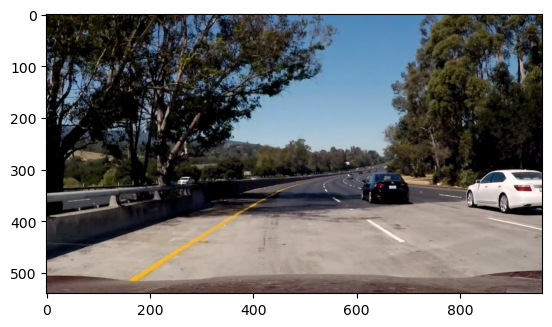

In [3]:
#reading in an image
image = mpimg.imread('test_images/challenge.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image, cmap='gray')

In [5]:
class Lane(object):    
    CRITICAL_SLOPE_CHANGE = 0.1
    MOSTLY_HORIZONTAL_SLOPE = 0.4
    MAX_SLOPE_DIFFERENCE = 0.8
    MAX_DISTANCE_FROM_LINE = 20
    BUFFER_FRAMES = 10
    COLORS = {
        'lane_color': (255,0,0),
        'region_stable': (0,80,60),
        'region_unstable': (255,80,60),
        'left_line': (60,40,220),
        'right_line': (255,0,255)
    }
    THICKNESS = 5
    FIRST_FRAME_LINE_RANGES = {'left_line': range(480), 
                               'right_line': range(480,960)}
    
    DECISION_MAT = [[.1,.9],[1,0]]
    
    left_line = None
    right_line = None
    
    @staticmethod
    def lines_exist():
        return all([Lane.left_line, Lane.right_line])
    
    @staticmethod
    def fit_lane_line(segments):
        """
        Lines interpolation using a linear regression.
        Any order of polynomial can be used, but we limit ourselves with 1st order for now.
        """
        x, y = [], []
    
        for line in segments:
            if line.candidate:
                x_coords = list(range(line.x1, line.x2, 1))
                y_coords = list(map(line.get_y_coord, x_coords))
                x.extend(x_coords)
                y.extend(y_coords)
                
        # Assisted lane lines detection for the 1st video frame
        if x != [] and not Lane.lines_exist():
            lane_line = segments[0].lane_line
            coords = np.array([[x, y] for x,y in zip(x, y)
                               if x in Lane.FIRST_FRAME_LINE_RANGES[lane_line]])
            x = coords[:,0]
            y = coords[:,1]
        if x != []:
            poly_coeffs = np.polyfit(x, y, 1)
            return poly_coeffs, list(zip(x, y))
        else: return None, None
    
    @staticmethod
    def update_vanishing_point(left, right):
        equation = left.coeffs - right.coeffs
        x = -equation[1] / equation[0]
        y = np.poly1d(left.coeffs)(x)
        x, y = map(int, [x, y])
        left.vanishing_point = [x, y]
        right.vanishing_point = [x, y]
        
    @staticmethod
    def purge():
        Lane.left_line = None
        Lane.right_line = None
    
    def __init__(self, segments):
        """
        Since lane line can be any order polynomial, I keep all poly coefficients
        in an array -- this is mostly for the future.
        """
        buffer_frames = Lane.BUFFER_FRAMES
        
        # Lane coefficients from the current image
        self.current_lane_line_coeffs, self.points = Lane.fit_lane_line(segments)
        
        if self.current_lane_line_coeffs is None: 
            raise Exception('Cannot initialize lane. No lines detected.')
        
        # Buffer for lane line smoothing
        self.buffer = np.array(buffer_frames * [self.current_lane_line_coeffs])        
        self.coeffs = self.buffer[0]        
        self.stable = True
        
        # Hough lines which belong to this lane line
        self.segments = None
        
        # List of points which belong to this lane line. Transformed from segments
        self.points = None
        
        # Coordinates for drawing this lane line
        self.x1, self.x2, self.y1, self.y2 = 0,0,0,0
        
    @property
    def a(self):
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[0]
    
    @property
    def b(self):
        if len(self.coeffs) > 2: 
            return Exception("You have a higher order polynomial for Lane, but you treat it as a line.")
        return self.coeffs[1]
    
    def update_lane_line(self, segments):
        average_buffer = np.average(self.buffer, axis=0)
        self.coeffs = np.average(self.buffer, axis=0)
        self.update_current_lane_line_coeffs(segments)
        weights = Lane.DECISION_MAT[self.stable]
        current_buffer_coeffs = np.dot(weights, np.vstack([self.current_lane_line_coeffs, average_buffer]))
        self.buffer = np.insert(self.buffer, 0, current_buffer_coeffs, axis=0)[:-1]
        self.update_lane_line_coords()
    
    def update_current_lane_line_coeffs(self, segments):
        lane_line_coeffs, points = Lane.fit_lane_line(segments)
        if lane_line_coeffs is None:
            lane_line_coeffs = np.average(self.buffer, axis=0)
        if points is not None:
            self.points = points
        average_buffer = np.average(self.buffer, axis=0)
        buffer_slope = average_buffer[0]
        current_slope = lane_line_coeffs[0]
        self.current_lane_line_coeffs = lane_line_coeffs
        if abs(current_slope - buffer_slope) > Lane.CRITICAL_SLOPE_CHANGE:
            self.stable = False
        else: self.stable = True
            
    def update_segments_list(self, segments):
        self.segments = segments
    
    def get_x_coord(self, y):
        return int((y - self.coeffs[1]) / self.coeffs[0])
    
    def update_lane_line_coords(self):
        # Offset to distinguish lines
        visual_offset = 20
        self.y1 = image.shape[1]
        self.x1 = self.get_x_coord(self.y1)
        self.y2 = self.vanishing_point[1] + visual_offset
        self.x2 = self.get_x_coord(self.y2)
          
class Line(object):
    """
    Line: y = ax + b.
    A line can be described by its pair of coordinates (x1, y1), (x2, y2).
    To formalize a line, need to compute its slope (a) and intercept (b).
    """
    
    def __init__(self, x1, y1, x2, y2):
        if x1 > x2: (x1, y1), (x2, y2) = (x2, y2), (x1, y1)
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        self.a = self.compute_slope()
        self.b = self.compute_intercept()
        self.lane_line = self.assign_to_lane_line()
        
        
    def __repr__(self):
        return 'Line: x1={}, y1={}, x2={}, y2={}, a={}, b={}, candidate={}, line={}'.format(
                self.x1, self.y1, self.x2, self.y2, round(self.a,2), 
                round(self.b,2), self.candidate, self.lane_line)
    
    def get_coords(self):
        return (self.x1, self.y1, self.x2, self.y2)

    def get_x_coord(self, y):
        return int((y - self.b) / self.a)
    
    def get_y_coord(self, x):
        return int(self.a * x + self.b)
    
    def compute_slope(self):
        return (self.y2 - self.y1) / (self.x2 - self.x1)
    
    def compute_intercept(self):
        return self.y1 - self.a * self.x1
    
    @property
    def candidate(self):
        if abs(self.a) < Lane.MOSTLY_HORIZONTAL_SLOPE: return False
        lane_line = getattr(Lane, self.lane_line)
        if lane_line:
            if abs(self.a - lane_line.coeffs[0]) > Lane.MAX_SLOPE_DIFFERENCE: return False
            if self.distance_to_lane_line > Lane.MAX_DISTANCE_FROM_LINE: return False
            if self.y2 < Lane.left_line.vanishing_point[1]: return False
        return True
    
    def assign_to_lane_line(self):
        if self.a < 0.0: return 'left_line'
        else: return 'right_line'
        
    @property
    def distance_to_lane_line(self):
        """
        Reference https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
        """
        lane_line = getattr(Lane, self.lane_line)
        if lane_line is None: return None
        avg_x = (self.x2 + self.x1) / 2
        avg_y = (self.y2 + self.y1) / 2
        distance = abs(lane_line.a * avg_x - avg_y + 
                   lane_line.b) / math.sqrt(lane_line.a ** 2 + 1)
        return distance

In [6]:
def gimp_to_opencv_hsv(*hsv):
    """
    I used GIMP to visualize colors. This is a GIMP => CV2 HSV format converter.
    """
    return (hsv[0] / 2, hsv[1] / 100 * 255, hsv[2] / 100 * 255)

ROI_VERTICES = np.array([[(50, 540), (420, 330), (590, 330), 
                      (960 - 50, 540)]], dtype=np.int32)    

# White and yellow color thresholds for lines masking.
WHITE_LINES = { 'low_th': gimp_to_opencv_hsv(0, 0, 80),
                'high_th': gimp_to_opencv_hsv(359, 10, 100) }

YELLOW_LINES = { 'low_th': gimp_to_opencv_hsv(35, 20, 30),
                 'high_th': gimp_to_opencv_hsv(65, 100, 100),
                 'kernel': np.ones((3,3),np.uint64)}

def get_lane_lines_mask(hsv_image, colors):
    masks = []
    for color in colors:
        if 'low_th' in color and 'high_th' in color:
            mask = cv2.inRange(hsv_image, color['low_th'], color['high_th'])
            if 'kernel' in color:
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, color['kernel'])
            masks.append(mask)
        else: raise Exception('High or low threshold values missing')
    if masks:
        return cv2.add(*masks)
    
def hough_line_transform(image, rho, theta, threshold, min_line_length, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    if lines is not None:
        filtered_lines = list(filter(lambda l: l.candidate, map(lambda line: Line(*line[0]), lines)))
        return filtered_lines
    else: return None
    
def update_lane(segments):
    if segments is not None:
        left = [segment for segment in segments if segment.lane_line == 'left_line']
        right = [segment for segment in segments if segment.lane_line == 'right_line']
        if not Lane.lines_exist():
            Lane.left_line = Lane(left)
            Lane.right_line = Lane(right)      
        Lane.update_vanishing_point(Lane.left_line, Lane.right_line)
        Lane.left_line.update_lane_line([l for l in left if l.candidate])
        Lane.right_line.update_lane_line([r for r in right if r.candidate])

def image_pipeline(image):
    """
    Image pipeline with 3 phases:
    * Raw image preprocessing and noise filtering;
    * Lane lines state update with the information gathered in preprocessing phase;
    * Drawing updated lane lines and other objects on image.
    """

    ### Phase 1: Image Preprocessing

    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    binary_mask = get_lane_lines_mask(hsv_image, [WHITE_LINES, YELLOW_LINES])

    masked_image = draw_binary_mask(binary_mask, hsv_image)

    blank_image = np.zeros_like(image)

    edges_mask = canny(masked_image, 280, 360)
    
    if not Lane.lines_exist():
        edges_mask = region_of_interest(edges_mask, ROI_VERTICES)
    
    edges_image = draw_canny_edges(edges_mask, blank_image)
    
    segments = hough_line_transform(edges_mask, 1, math.pi / 180, 5, 5, 8)
    
    ### Stage 2: Lane lines state update
    
    update_lane(segments)

    ### Stage 3: Drawing

    # Snapshot 1
    out_snap1 = np.zeros_like(image)
    out_snap1 = draw_binary_mask(binary_mask, out_snap1)
    out_snap1 = draw_filtered_lines(segments, out_snap1)
    snapshot1 = cv2.resize(deepcopy(out_snap1), (240,135))
    
    # Snapshot 2
    out_snap2 = np.zeros_like(image)
    out_snap2 = draw_canny_edges(edges_mask, out_snap2)
    out_snap2 = draw_points(Lane.left_line.points, out_snap2, Lane.COLORS['left_line'])
    out_snap2 = draw_points(Lane.right_line.points, out_snap2, Lane.COLORS['right_line'])
    out_snap2 = draw_lane_polygon(out_snap2)
    snapshot2 = cv2.resize(deepcopy(out_snap2), (240,135))
    
    # Augmented image
    output = deepcopy(image)
    output = draw_lane_lines([Lane.left_line, Lane.right_line], output, shade_background=True)
    output = draw_dashboard(output, snapshot1, snapshot2)
    return output

In [7]:
def draw_binary_mask(binary_mask, img):
    if len(binary_mask.shape) != 2: 
        raise Exception('binary_mask: not a 1-channel mask. Shape: {}'.format(str(binary_mask.shape)))
    masked_image = np.zeros_like(img)
    for i in range(3): 
        masked_image[:,:,i] = binary_mask.copy()
    return masked_image

def draw_canny_edges(binary_mask, img):
    return draw_binary_mask(binary_mask, img)

def draw_filtered_lines(lines, img, color=[255, 0, 0], thickness=2):
    """
    Uses the output of `hough_line_transform` function to draw lines on an image.
    """
    if lines is None: return img
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for line in lines:
        x1,y1,x2,y2 = line.get_coords()
        cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    return weighted_img(line_img, img)

def draw_points(points, img, color=(255,255,0)):
    if points is None: return img
    for point in points:
        cv2.circle(img, point, 2, color, -1)
    return img

def draw_lane_lines(lane_lines, img, shade_background=False):
    if shade_background: α = 0.8
    else: α = 1.
    lane_line_image = np.zeros_like(img)
    for line in lane_lines:
        line.update_lane_line_coords()
        cv2.line(lane_line_image, (line.x1, line.y1), (line.x2, line.y2), 
                    Lane.COLORS['lane_color'], Lane.THICKNESS)
    return weighted_img(lane_line_image, img, α=α, β=1.)
  
def draw_lane_polygon(img):
    offset_from_lane_edge = 20
    color = Lane.COLORS['region_stable']
    
    if not Lane.lines_exist(): return img

    # Polygon points
    p1 = [Lane.left_line.x1,Lane.left_line.y1]
    p2 = [Lane.left_line.get_x_coord(Lane.left_line.y2 + offset_from_lane_edge),
                                     Lane.left_line.y2 + offset_from_lane_edge]
    p3 = [Lane.right_line.get_x_coord(Lane.left_line.y2 + offset_from_lane_edge),
                                      Lane.right_line.y2 + offset_from_lane_edge]
    p4 = [Lane.right_line.x1,Lane.right_line.y1]
    
    polygon_points = np.array([p1, p2, p3, p4], np.int32).reshape((-1,1,2))
    
    if not Lane.left_line.stable or not Lane.right_line.stable:
        color = Lane.COLORS['region_unstable']
    
    poly_img = np.zeros_like(img)
    cv2.fillPoly(poly_img,[polygon_points], color)
    return weighted_img(img, poly_img)

def draw_dashboard(img, snapshot1, snapshot2):
    # TODO: refactor this
    if not Lane.lines_exist(): return img
    cv2.CV_FILLED = -1
    image_copy = deepcopy(img)
    cv2.rectangle(image_copy, (0,0), (540,175), (0,0,0), cv2.CV_FILLED)
    img = weighted_img(image_copy, img, α=0.3, β=0.7)
    img[20:155,20:260,:] = snapshot1
    img[20:155,280:520,:] = snapshot2
    return img

def draw_on_gray_with_color_mask(img, binary_mask):
    """
    Returns a gray-ish image with colorized parts described in binary_mask.
    img should be a 3-channel image.
    """
    image_gray = grayscale(img)
    mask = np.zeros_like(img)
    color_mask = cv2.bitwise_and(img, img, mask= binary_mask)
    binary_mask_inv = cv2.bitwise_not(binary_mask)
    image_gray = cv2.bitwise_and(image_gray, image_gray, mask=binary_mask_inv)

    output = np.zeros_like(img)
    for i in range(3):
        output[:,:,i] = image_gray
    output = cv2.add(output, color_mask)
    return output

## Lane Detection Pipeline

In [8]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    
    #defining a 3 channel/1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images


In [9]:
image = mpimg.imread('test_images/challenge2.jpg')

C:\Users\prart\AppData\Local\Temp\ipykernel_22664\2246770741.py:199: RuntimeWarning: divide by zero encountered in int_scalars
  return (self.y2 - self.y1) / (self.x2 - self.x1)
C:\Users\prart\AppData\Local\Temp\ipykernel_22664\2246770741.py:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x != []:


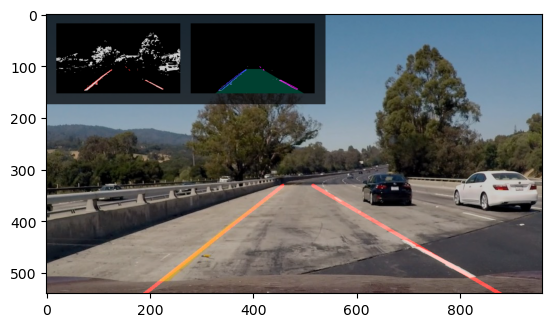

In [10]:
Lane.purge()
plt.imshow(image_pipeline(image))

In [11]:
import os
os.listdir("test_images/")

['challenge.jpg',
 'challenge2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



C:\Users\prart\AppData\Local\Temp\ipykernel_22664\2246770741.py:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if x != []:
C:\Users\prart\AppData\Local\Temp\ipykernel_22664\2246770741.py:199: RuntimeWarning: divide by zero encountered in int_scalars
  return (self.y2 - self.y1) / (self.x2 - self.x1)


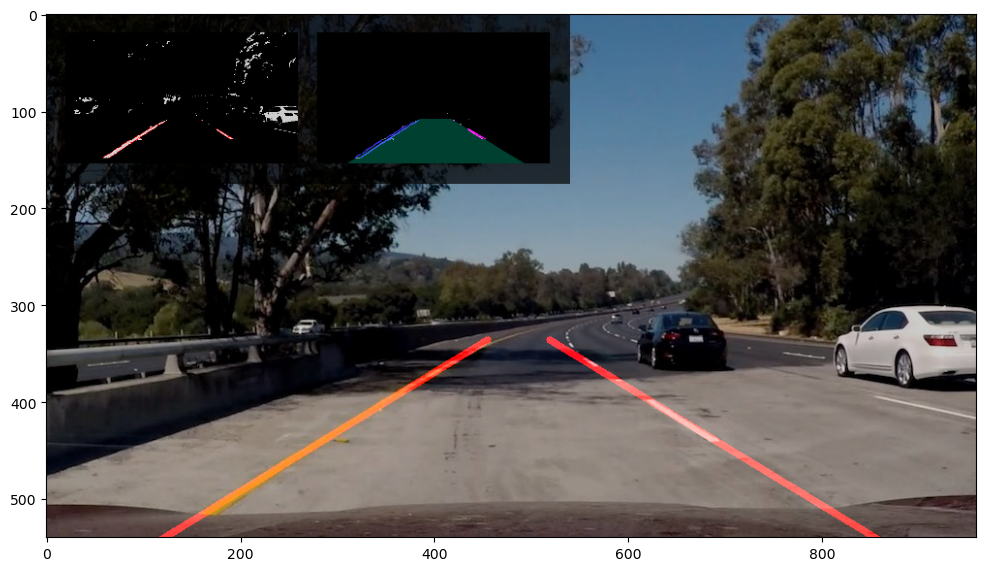

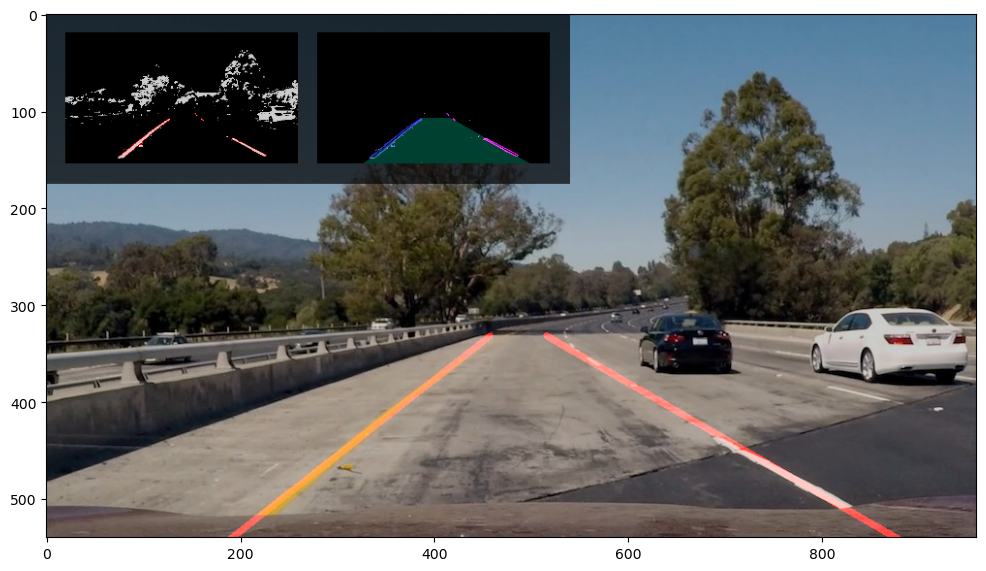

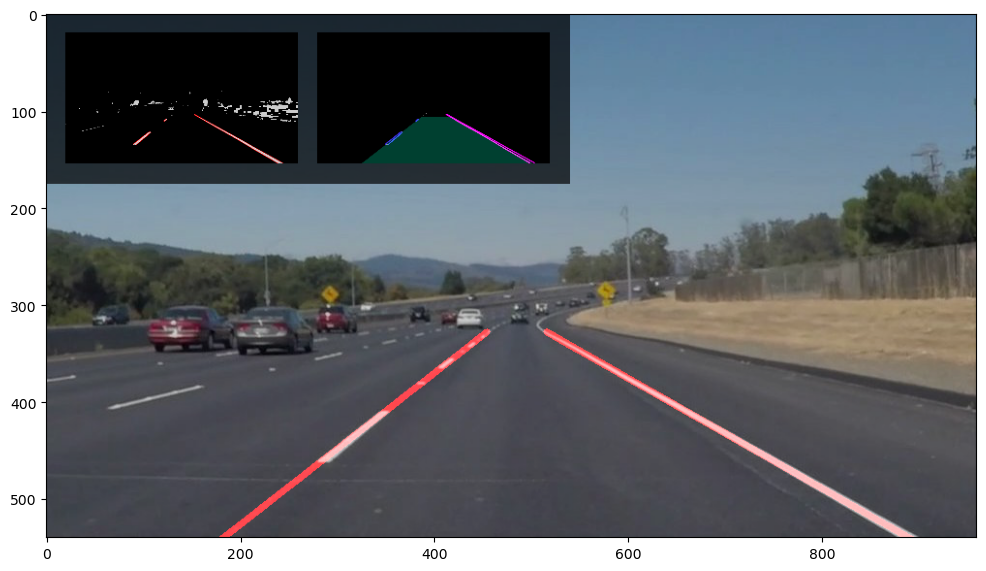

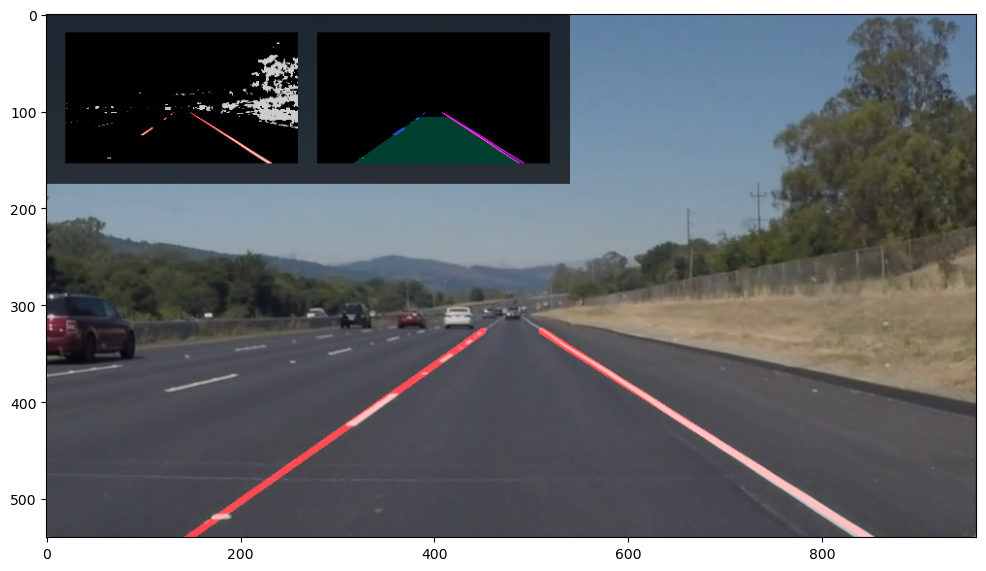

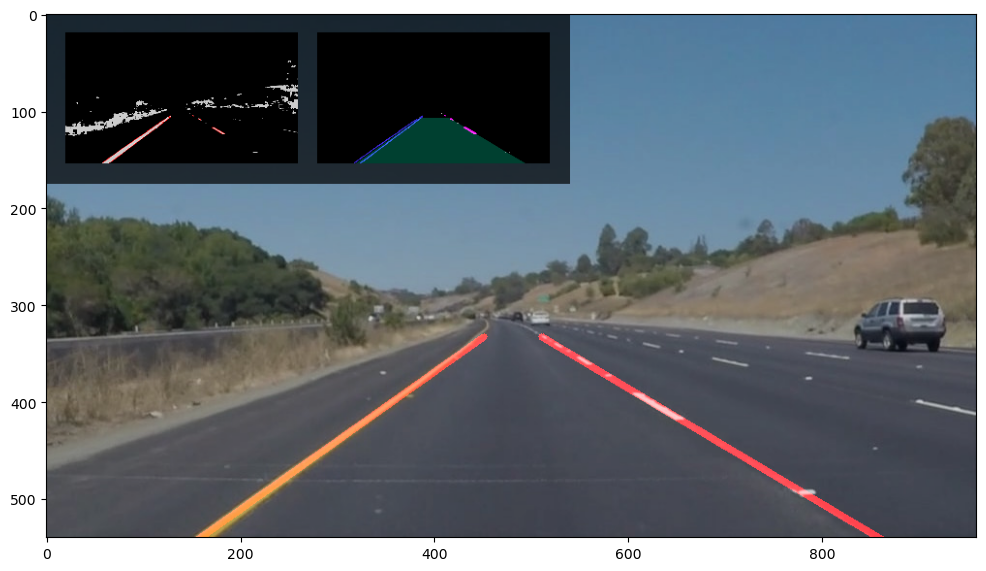

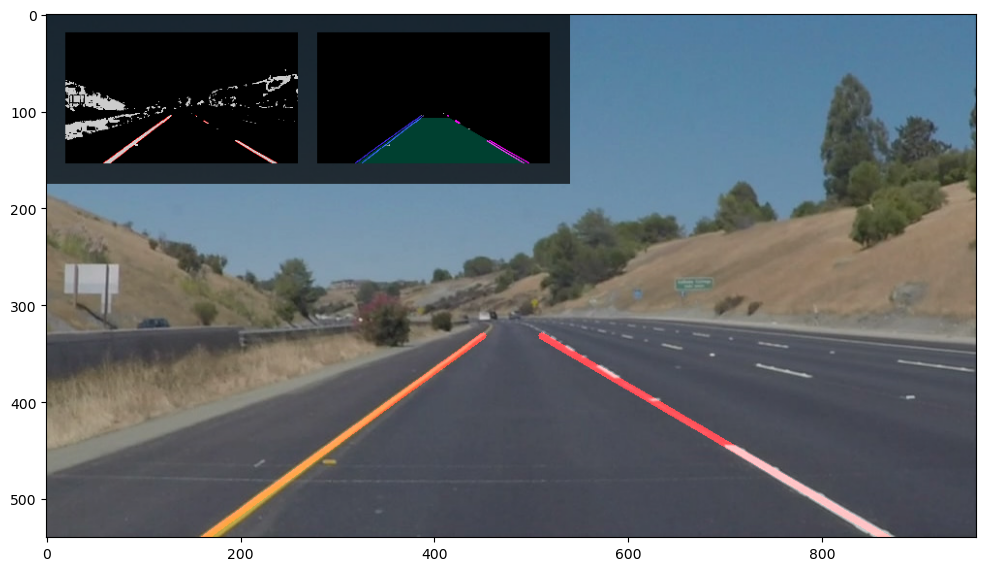

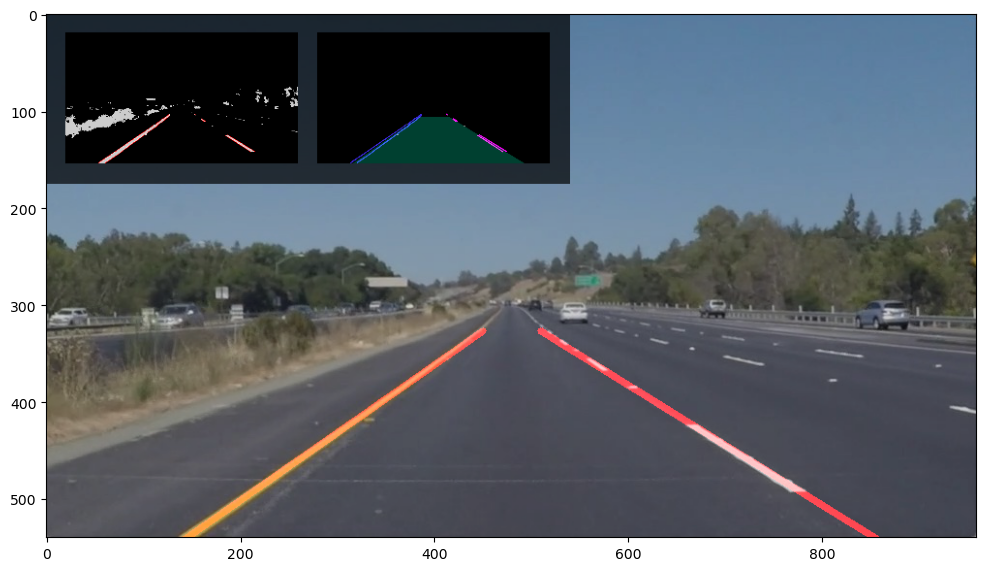

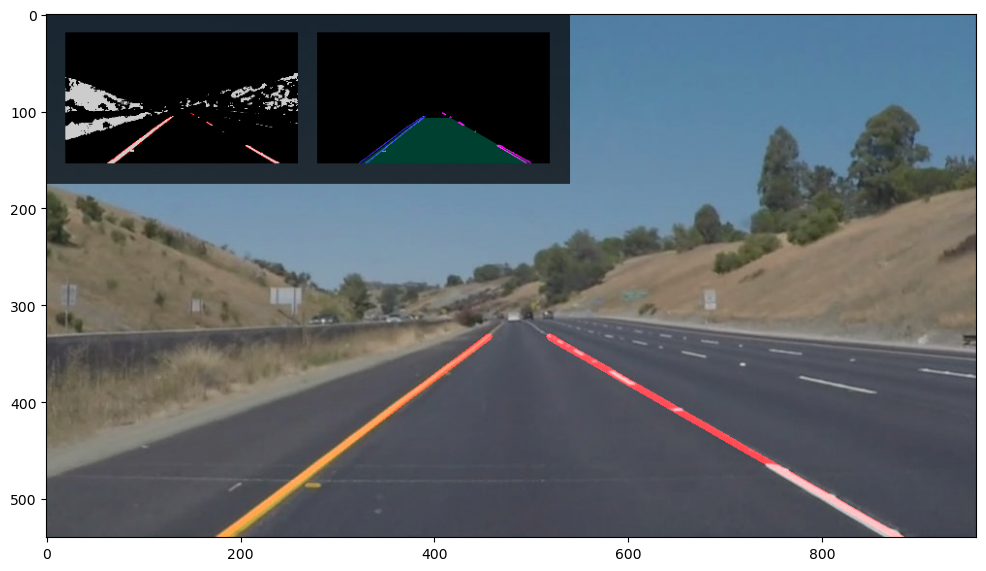

In [12]:
VERBOSE = False
for img in os.listdir("test_images/"):
    if img.endswith('jpg'):
        Lane.purge()
        plt.figure(figsize=(12,8))
        image = mpimg.imread('test_images/{}'.format(img))
        plt.imshow(image_pipeline(image))

## Test on Videos


In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    width = 960
    height = 540
    frame = cv2.resize(image, (960,540))
    return image_pipeline(frame)

In [18]:
Lane.purge()
white_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/white_alt.mp4'
clip1 = VideoFileClip("D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/white_alt.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/white_alt.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/white_alt.mp4
CPU times: total: 2.22 s
Wall time: 7.55 s


In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))

In [22]:
Lane.purge()
yellow_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/yellow.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/yellow.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/yellow.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/yellow.mp4
CPU times: total: 10.1 s
Wall time: 28.4 s


In [24]:
Lane.purge()
challenge_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/p4_output.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/project_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/p4_output.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/p4_output.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/p4_output.mp4
CPU times: total: 26.6 s
Wall time: 1min 3s


In [26]:
Lane.purge()
challenge_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)


Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra.mp4
CPU times: total: 11.6 s
Wall time: 27.4 s


In [28]:
Lane.purge()
easy_challenge_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra_2.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(easy_challenge_output, audio=False)

Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra_2.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra_2.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/extra_2.mp4
CPU times: total: 4.7 s
Wall time: 12.5 s


In [33]:
Lane.purge()
harder_challenge_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/harder_challenge.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/harder_challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)

Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/harder_challenge.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/harder_challenge.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/harder_challenge.mp4
CPU times: total: 1min 13s
Wall time: 1min 41s


In [22]:
Lane.purge()
Park_Part2_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Park_Part2_output.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/Park_Part1.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(Park_Part2_output, audio=False)

Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Park_Part2_output.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Park_Part2_output.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Park_Part2_output.mp4
CPU times: total: 19min 46s
Wall time: 35min 25s


In [ ]:
Lane.purge()
Utah_output = 'D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Utah_output.mp4'
clip2 = VideoFileClip('D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/input/Utah_1.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(Utah_output, audio=False)

Moviepy - Building video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Utah_output.mp4.
Moviepy - Writing video D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Utah_output.mp4



Moviepy - Done !
Moviepy - video ready D:/Self-Driving-Car/carnd/p1_lane_lines_detection/test_videos/output/Utah_output.mp4
CPU times: total: 58min 38s
Wall time: 1h 9min 49s
